In [ ]:
!pip install -q timm==0.9.2 torchmetrics==0.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 16.4 MB/s eta 0:00:00


# **PEST**

In [ ]:
import os, time, shutil, json, random
from pathlib import Path
import numpy as np
from PIL import Image
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
from torchvision import transforms


UPLOADED_SPLITS = "/content/drive/MyDrive/dataset_splits_final/splits.json"
LOCAL_SPLITS = "/content/splits_final.json"
DRIVE_DATASET = "/content/drive/MyDrive/rice_leaf_diseases"
LOCAL_DATA_ROOT = "/content/rice"
CHECKPOINT_DRIVE = "/content/drive/MyDrive/best_quick.pth"


if Path(UPLOADED_SPLITS).exists():
    shutil.copy(UPLOADED_SPLITS, LOCAL_SPLITS)
    print("Copied splits.json from session ->", LOCAL_SPLITS)
else:
    if not Path(LOCAL_SPLITS).exists():
        raise FileNotFoundError(f"Couldn't find splits at {UPLOADED_SPLITS} or {LOCAL_SPLITS}")


USE_GPU = torch.cuda.is_available()
device = torch.device("cuda" if USE_GPU else "cpu")
print("Device:", device)

if USE_GPU:

    MODEL_NAME = "mobilenetv3_large_100"
    IMG_SIZE = 160
    BATCH_SIZE = 16
    NUM_WORKERS = 2
else:

    print("WARNING: GPU not available. Training on CPU will be very slow. Enable GPU in Runtime settings.")
    MODEL_NAME = "mobilenetv3_small_100"
    IMG_SIZE = 128
    BATCH_SIZE = 8
    NUM_WORKERS = 0

LR = 2e-4
EPOCHS = 10
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if USE_GPU: torch.cuda.manual_seed_all(SEED)

if not Path(LOCAL_DATA_ROOT).exists():
    if Path(DRIVE_DATASET).exists():
        print("Copying dataset from Drive to local VM (/content). This runs once and speeds up training.")
        shutil.copytree(DRIVE_DATASET, LOCAL_DATA_ROOT)
        print("Dataset copied to", LOCAL_DATA_ROOT)
    else:
        print("Drive dataset path does not exist:", DRIVE_DATASET)
        print("If your dataset is already in /content, change DATA_ROOT accordingly.")

with open(LOCAL_SPLITS, "r") as f:
    splits = json.load(f)
classes = splits["classes"]
train_paths = splits["train"]
val_paths = splits["val"]
test_paths = splits["test"]
print("Loaded splits. #train, #val, #test:", len(train_paths), len(val_paths), len(test_paths))

if Path(LOCAL_DATA_ROOT).exists():
    def map_to_local(p): return p.replace("/content/drive/MyDrive/rice_leaf_diseases", LOCAL_DATA_ROOT)
    train_paths = [map_to_local(p) for p in train_paths]
    val_paths   = [map_to_local(p) for p in val_paths]
    test_paths  = [map_to_local(p) for p in test_paths]

class ImgDataset(Dataset):
    def __init__(self, paths, classes, transform=None):
        self.paths = paths
        self.transform = transform
        self.cls_to_idx = {c:i for i,c in enumerate(classes)}
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        label = self.cls_to_idx[Path(p).parent.name]
        return img, label

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

train_ds = ImgDataset(train_paths, classes, transform=train_tf)
val_ds   = ImgDataset(val_paths, classes, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# 9) Build model (use timm model string)
print("Creating model:", MODEL_NAME)
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# 10) Tiny training loop (quick check)
print("Starting quick training run (EPOCHS=", EPOCHS, ") — this is for speed test and sanity only.")
best_val_acc = 0.0 # Initialize best validation accuracy

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    running = 0; correct = 0; total = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        preds = out.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running += loss.item()*labels.size(0)
    train_acc = correct/total if total else 0
    # quick val
    model.eval()
    vcorrect = 0; vtotal = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            vcorrect += (preds == labels).sum().item()
            vtotal += labels.size(0)
    val_acc = vcorrect / vtotal if vtotal else 0
    print(f"Epoch {epoch} — train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, time: {time.time()-t0:.1f}s")

    # Save the model if this is the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CHECKPOINT_DRIVE)
        print(f"  --> Saved best model to {CHECKPOINT_DRIVE} with Val Acc: {best_val_acc:.4f}")

print("Quick run finished. If this is fast, increase EPOCHS and tune sampler/augmentations.")
print("NOTE: If you still see CPU device, double-check you enabled GPU (Runtime → Change runtime type → GPU).")

Copied splits.json from session -> /content/splits_final.json
Device: cpu
Loaded splits. #train, #val, #test: 13449 2882 2882
Creating model: mobilenetv3_small_100
Starting quick training run (EPOCHS= 10 ) — this is for speed test and sanity only.
Epoch 1 — train_acc: 0.6473, val_acc: 0.7908, time: 849.2s
  --> Saved best model to /content/drive/MyDrive/best_quick.pth with Val Acc: 0.7908
Epoch 2 — train_acc: 0.7841, val_acc: 0.7738, time: 835.6s
Epoch 3 — train_acc: 0.8175, val_acc: 0.8418, time: 820.3s
  --> Saved best model to /content/drive/MyDrive/best_quick.pth with Val Acc: 0.8418
Epoch 4 — train_acc: 0.8537, val_acc: 0.8612, time: 832.5s
  --> Saved best model to /content/drive/MyDrive/best_quick.pth with Val Acc: 0.8612
Epoch 5 — train_acc: 0.8701, val_acc: 0.9105, time: 825.5s
  --> Saved best model to /content/drive/MyDrive/best_quick.pth with Val Acc: 0.9105
Epoch 6 — train_acc: 0.8872, val_acc: 0.8917, time: 832.7s
Epoch 7 — train_acc: 0.9055, val_acc: 0.9303, time: 840.2s

In [ ]:
import json
from pathlib import Path

pest_map = {
    "Bacterial_leaf_blight": "Streptocycline",
    "Brown_spot": "Tebuconazole",
    "Healthy_Rice_Leaf": None,
    "Leaf_Blast": "Tricyclazole",
    "Leaf_scald": "Carbendazim",
    "Leaf_smut": "Propiconazole",
    "Neck_Blast": "Tricyclazole",
    "Rice_Hispa": "Chlorpyrifos",
    "Sheat_Blight": "Propiconazole",
    "narrow_brown_spot": "Propiconazole"
}


area_map = {
    "one_acre_cm2": 40468600,
    "mini_farm_cm2": 512
}

scale_factor = area_map["mini_farm_cm2"] / area_map["one_acre_cm2"]

WATER_PER_ACRE_L = 200
water_info = {
    "water_liters_per_acre": WATER_PER_ACRE_L,
    "water_liters_mini_farm": WATER_PER_ACRE_L * scale_factor
}

acre_dosage = {
    "Bacterial_leaf_blight": {"Streptocycline_g": 1},
    "Brown_spot": {"Tebuconazole_ml": 200},
    "Healthy_Rice_Leaf": {},
    "Leaf_Blast": {"Tricyclazole_g": 120},
    "Leaf_scald": {"Carbendazim_g": 200},
    "Leaf_smut": {"Propiconazole_ml": 200},
    "Neck_Blast": {"Tricyclazole_g": 120},
    "Rice_Hispa": {"Chlorpyrifos_ml": 500},
    "Sheat_Blight": {"Propiconazole_ml": 200},
    "narrow_brown_spot": {"Propiconazole_ml": 200}
}


mini_farm_dosage = {}

for pest, chemicals in acre_dosage.items():
    mini_farm_dosage[pest] = {}
    for chem, amount in chemicals.items():
        mini_farm_dosage[pest][chem] = amount * scale_factor


final_output = {
    "area_info": area_map,
    "scale_factor": scale_factor,
    "water_info": water_info,
    "recommendations": {}
}

for pest in pest_map:
    final_output["recommendations"][pest] = {
        "pesticide": pest_map[pest],
        "acre_dose": acre_dosage.get(pest, {}),
        "mini_farm_dose": mini_farm_dosage.get(pest, {})
    }


json_path = "/content/drive/MyDrive/pest_pesticide_map_final.json"

Path(json_path).parent.mkdir(parents=True, exist_ok=True)

with open(json_path, "w") as f:
    json.dump(final_output, f, indent=4)

print("Unified JSON saved to:", json_path)
print("Scale factor used:", scale_factor)
print("Water per acre (L):", WATER_PER_ACRE_L)
print("Water for mini farm (L):", water_info["water_liters_mini_farm"])

Unified JSON saved to: /content/drive/MyDrive/pest_pesticide_map_final.json
Scale factor used: 1.2651784346382134e-05
Water per acre (L): 200
Water for mini farm (L): 0.002530356869276427


Classes: ['Bacterial_leaf_blight', 'Brown_spot', 'Healthy_Rice_Leaf', 'Leaf_Blast', 'Leaf_scald', 'Leaf_smut', 'Neck_Blast', 'Rice_Hispa', 'Sheat_Blight', 'narrow_brown_spot']
Pesticide mapping loaded.
Area info: {'one_acre_cm2': 40468600, 'mini_farm_cm2': 512}
Scale factor: 1.2651784346382134e-05
Water per acre (L): 200
Water for mini farm (L): 0.002530356869276427
Model loaded successfully on cpu
Upload a rice leaf image:


Saving brown_spot.jpeg to brown_spot (4).jpeg
Image uploaded: /content/brown_spot (4).jpeg

 PREDICTED PEST            : Brown_spot
 CONFIDENCE                : 0.9444
------------------------------
 TARGET GRID (SMART SPRAY) : Grid #2
------------------------------
 RECOMMENDED PESTICIDE     : Tebuconazole

 FIELD DOSE (per acre):
Tebuconazole_ml: 200.000000
Water required: 200 liters

 MINI-FARM DOSE (16×32 cm):
Tebuconazole_ml: 0.002530
Water required: 0.0025 liters (2.53 ml)



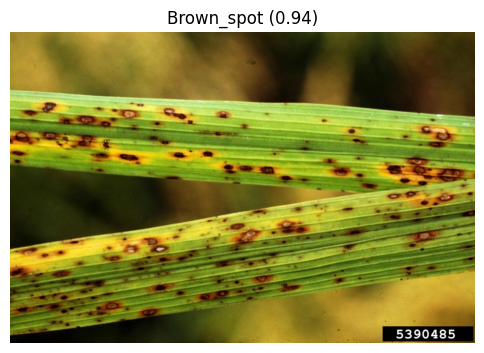

In [ ]:
# ===== Prediction code with JSON-based pesticide + dosage lookup =====

import json
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms
import timm
from google.colab import files
import random   # <-- for random grid selection

# --------------------------
# CONFIG
# --------------------------
CHECKPOINT_PATH = "/content/drive/MyDrive/best_quick.pth"
SPLITS_PATH = "/content/drive/MyDrive/dataset_splits_final/splits.json"
PESTICIDE_JSON = "/content/drive/MyDrive/pest_pesticide_map_final.json"

MODEL_ARCH = "mobilenetv3_small_100"
IMG_SIZE = 128

# --------------------------
# LOAD CLASS NAMES
# --------------------------
with open(SPLITS_PATH, "r") as f:
    splits = json.load(f)
classes = splits["classes"]
print("Classes:", classes)

# --------------------------
# LOAD PESTICIDE UNIFIED JSON
# --------------------------
with open(PESTICIDE_JSON, "r") as f:
    pesticide_data = json.load(f)

area_info = pesticide_data.get("area_info", {})
scale_factor = pesticide_data.get("scale_factor", None)
recommendations = pesticide_data.get("recommendations", {})
water_info = pesticide_data.get("water_info", {})

# Fallbacks if not present
WATER_PER_ACRE_L = water_info.get("water_liters_per_acre", 200)
WATER_MINI_FARM_L = water_info.get(
    "water_liters_mini_farm",
    WATER_PER_ACRE_L * (area_info.get("mini_farm_cm2", 512) / area_info.get("one_acre_cm2", 40468600))
)

print("Pesticide mapping loaded.")
print("Area info:", area_info)
print("Scale factor:", scale_factor)
print("Water per acre (L):", WATER_PER_ACRE_L)
print("Water for mini farm (L):", WATER_MINI_FARM_L)

# --------------------------
# LOAD MODEL
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(MODEL_ARCH, pretrained=False, num_classes=len(classes))
state = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
model.load_state_dict(state)
model.to(device)
model.eval()

print("Model loaded successfully on", device)

# --------------------------
# PREPROCESSING
# --------------------------
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# --------------------------
# HELPER: FORMAT DOSE DICTIONARY AS TEXT
# --------------------------
def format_dose(dose_dict):
    if not dose_dict:
        return "No dose required / Not applicable"
    lines = []
    for chem, amount in dose_dict.items():
        if isinstance(amount, (int, float)):
            lines.append(f"{chem}: {amount:.6f}")
        else:
            lines.append(f"{chem}: {amount}")
    return "\n".join(lines)

# --------------------------
# PREDICT FUNCTION
# --------------------------
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        probs = F.softmax(out, dim=1).cpu().numpy()[0]

    pred_index = probs.argmax()
    pest_name = classes[pred_index]
    confidence = float(probs[pred_index])

    # Look up full recommendation from unified JSON
    rec = recommendations.get(pest_name, None)

    if rec is None:
        pesticide_name = "No data available for this pest"
        acre_dose = {}
        mini_farm_dose = {}
    else:
        pesticide_name = rec.get("pesticide", None)
        acre_dose = rec.get("acre_dose", {}) or {}
        mini_farm_dose = rec.get("mini_farm_dose", {}) or {}

        if pesticide_name is None:
            pesticide_name = "No pesticide needed (e.g., Healthy leaf)"

    return pest_name, confidence, pesticide_name, acre_dose, mini_farm_dose, img

# --------------------------
# IMAGE UPLOAD + PREDICTION
# --------------------------
print("Upload a rice leaf image:")
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    image_path = f"/content/{filename}"
    print("Image uploaded:", image_path)

    pest, conf, pesticide_name, acre_dose, mini_farm_dose, display_img = predict_image(image_path)

    # Random grid between 1 and 4
    grid_number = random.randint(1, 4)

    # PRINT RESULTS
    print("\n==============================")
    print(f" PREDICTED PEST            : {pest}")
    print(f" CONFIDENCE                : {conf:.4f}")
    print("------------------------------")
    print(f" TARGET GRID (SMART SPRAY) : Grid #{grid_number}")
    print("------------------------------")
    print(f" RECOMMENDED PESTICIDE     : {pesticide_name}")

    print("\n FIELD DOSE (per acre):")
    print(format_dose(acre_dose))
    print(f"Water required: {WATER_PER_ACRE_L} liters")

    print("\n MINI-FARM DOSE (16×32 cm):")
    print(format_dose(mini_farm_dose))
    print(f"Water required: {WATER_MINI_FARM_L:.4f} liters "
          f"({WATER_MINI_FARM_L*1000:.2f} ml)")
    print("==============================\n")

    # SHOW IMAGE
    plt.figure(figsize=(6,6))
    plt.imshow(display_img)
    plt.axis("off")
    plt.title(f"{pest} ({conf:.2f})")
    plt.show()
else:
    print("No image uploaded.")
